In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import datetime as dt

In [2]:
# new_price = pd.read_csv('HOEP.csv')
# price = pd.read_csv('HOEP_2002-2017.csv')
# price = price.append(new_price, ignore_index=True)

new_demand = pd.read_csv('HourlyDemands.csv')
demand = pd.read_csv('HourlyDemands_2002-2017.csv')
demand = demand.append(new_demand, ignore_index=True)

In [3]:
demand.head()

,Date,Hour,Total Market Demand,Ontario Demand
0,01-May-02,1,14141,14137
1,01-May-02,2,13876,13872
2,01-May-02,3,13974,13820
3,01-May-02,4,13898,13744
4,01-May-02,5,14378,14224


In [4]:
from multiprocessing import cpu_count, Pool
num_partitions = 16
num_cores = 8

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [5]:
def to_datetime(x: pd.DataFrame) -> pd.DataFrame:
    x['Date'] = pd.to_datetime(x['Date'], format='%d-%b-%y')
    return x

df = demand.copy(deep=True)
df = parallelize_dataframe(df, to_datetime)
df = df.pivot(index='Date', columns='Hour', values='Ontario Demand')
#df = df.resample('M').mean()

In [6]:
import scipy.io

dates = df.index.strftime("%Y-%m-%d")

scipy.io.savemat('z_values.mat', {'mdict': df.values})
scipy.io.savemat('x_values.mat', {'mdict': dates})

In [7]:
date_list = df.index.to_pydatetime().tolist()
df.reset_index(drop=True, inplace=True)

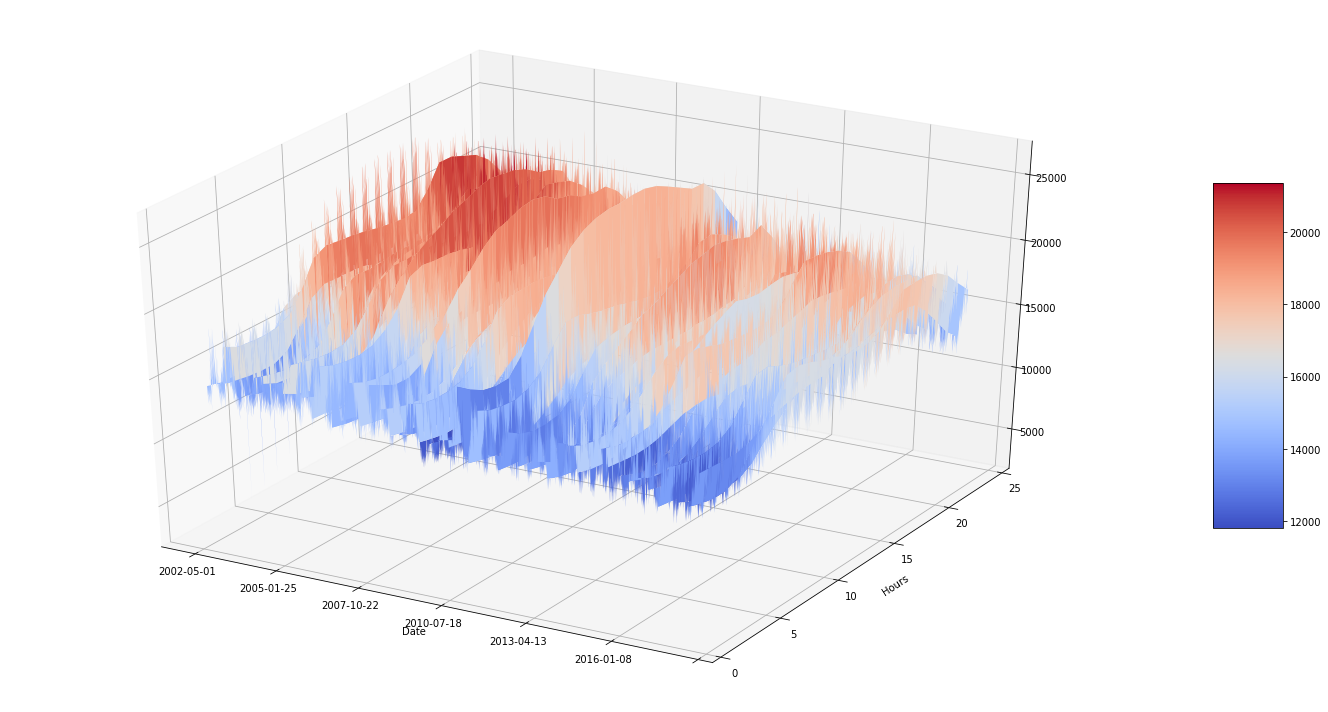

In [8]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
X = np.asarray(df.index.tolist())
Y = np.asarray(range(1,25))
X, Y = np.meshgrid(X, Y)
Z = np.asarray(df.values.tolist()).T
Z = np.nan_to_num(Z)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim(np.amin(Z), np.amax(Z))
fig.canvas.draw()
labels = ax.get_xticklabels()
newlabels = []
for label in labels[:-3]:
    newlabels.append(int(label.get_text()))
ax.xaxis.set_ticklabels([date_list[i].strftime("%Y-%m-%d") for i in newlabels])
plt.ylabel('Hours')
plt.xlabel('Date')
ax.view_init(32, 300)
plt.tight_layout()
plt.show()